In [1]:
%matplotlib inline

from IPython.display import Audio

from matplotlib import pyplot as plt
import numpy as np

from scipy.io import wavfile
from scipy import signal

import librosa
import librosa.display


In [2]:
path_clean = 'sp03.wav'
Audio(path_clean)

In [3]:
rate, data = wavfile.read('sp03.wav')
duration = len(data)/rate
print("the sample rate is {} KHz".format(rate/1000))
print("The duration is {:.2f} s".format(duration))
print(len(data))

the sample rate is 16.0 KHz
The duration is 14.06 s
225023


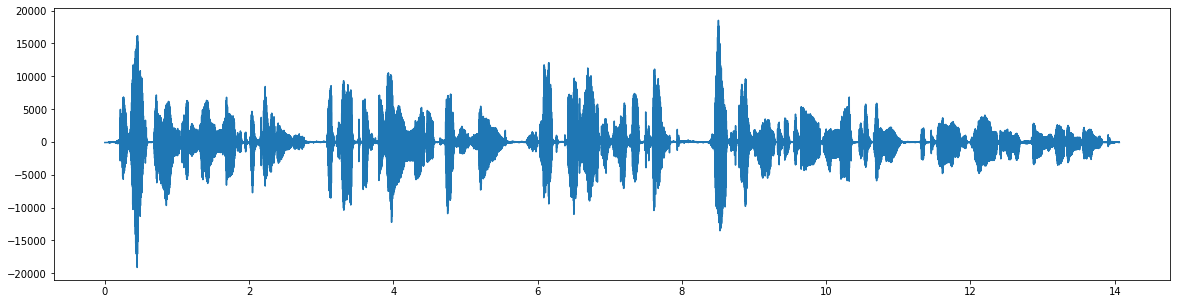

In [7]:
time = np.arange(len(data))/rate
plt.figure(figsize=[20, 5])
plt.plot(time, data)

# Using librosa.effects.split to remove silence

In [205]:
# split the signal into frames
data_ = np.array(data, dtype='float32')
inds = librosa.effects.split(data_, top_db=40)
print(inds)
# for each frame we will take the stft


[[     0  45568]
 [ 48640  90624]
 [ 93184 130048]
 [133632 177664]
 [180224 224256]]


In [206]:
data_nonsilent = data
l = []
for i in inds:
    l.append( data_nonsilent[i[0]:i[1]] )
data_nonsilent = np.concatenate(l,axis=0)

225023 212480
14.0639375 13.28


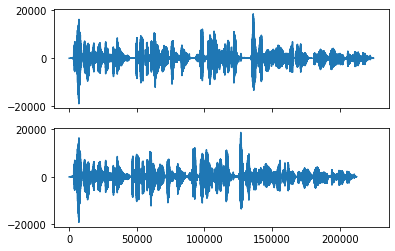

In [210]:
fig, ax = plt.subplots(2, 1, sharex=True)
ax[0].plot(data)
ax[1].plot(data_nonsilent)
print(len(data), len(data_nonsilent))
print(len(data)/rate, len(data_nonsilent)/rate)

In [208]:
Audio(data=data_nonsilent, rate=rate)

# Lets do it without Librosa

# cut out the silent parts of the speech
To do this we will split up the audio into windows/frames and overlap the windows by 50%
for each window, we will get the RMS, which is defined by the following equation:
\begin{align}
\sqrt{ \frac{1}{N} \sum_n |x(n)|^2}
\end{align}

In [83]:
# calculate the energy of the signal, which is the total magnitude of the signal
# calculate this by splitting up the signal into overlapping frames
# this is called the overlap-add method
def get_energy(data, frame_length=400, hop_length=200):
    print(frame_length, hop_length)
    energy = np.array([
        np.sqrt(sum(abs(data[i:i+frame_length]**2))/frame_length)
        for i in range(0, len(data), hop_length)
    ])
    return energy

In [84]:
def get_rms(data, frame_length=400, hop_length=100):
    '''
    convert samples to frames and get the rms for each frame
    '''
    energy = get_energy(data, frame_length=frame_length, hop_length=hop_length)
    #print((energy))
    #rms = np.sqrt(energy/len(energy))
    return energy

# This is what the rms looks like across frame number

3200 200


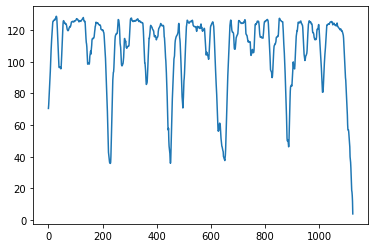

In [134]:
d = get_rms(data, frame_length=3200, hop_length=200)
plt.plot(d)
#plt.xlim(0, 100)

# Now we can make a function to loop through each frame and collecting the frame index whose rms is below a given threshold. Then we can convert frames back to samples to visualize our signal 

In [198]:
def strip(x, thresh=50, frame_length=400, hop_length=200):

    # use overlap-add method to get the short-time energy
    # energy = get_energy(x, frame_length=frame_length, hop_length=hop_length)
    # Compute RMSE.
    # rms = np.sqrt((data**2)/len(data))**2
    # Compute RMSE.
    rms = get_rms(data, frame_length=frame_length, hop_length=hop_length)
    plt.plot(rms)
    # get threshold crossings
    idx = []
    
    threshold_crossings = np.diff(rms > thresh, prepend=False)
    idx = np.argwhere(threshold_crossings)[:, 0]
        
    # Convert units of frames to samples using the hop_length/overlap
    start_sample_index = (np.asarray(idx) * hop_length).astype(int)
    
    return start_sample_index


2000 200


array([     0,  44400,  47600,  89400,  92000, 128600, 132400, 176600,
       179000, 223200])

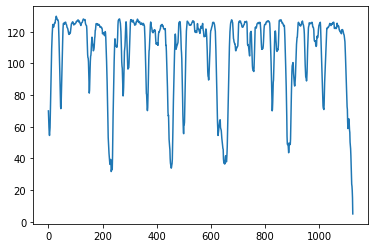

In [218]:
inds = strip((data), 50, frame_length=2000, hop_length=200)
inds

# now we can plot circles on the audio signal, which shows when the RMS fell below a threshold. As you can see these are doing an ok job of catching the silent periods

225023 10


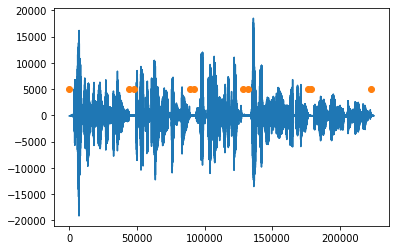

In [219]:
plt.plot(data)
plt.plot(inds, 5000*np.ones(len(inds)), 'o')

print(len(data), len(data[inds]))

# Now lets collect only the datapoints in between two indices and concatenate to get our nonsilent signal

[     0  44400  47600  89400  92000 128600 132400 176600 179000 223200]
[     0  44400  47600  89400  92000 128600 132400 176600 179000 223200]


Text(0.5, 0, 'Time (s)')

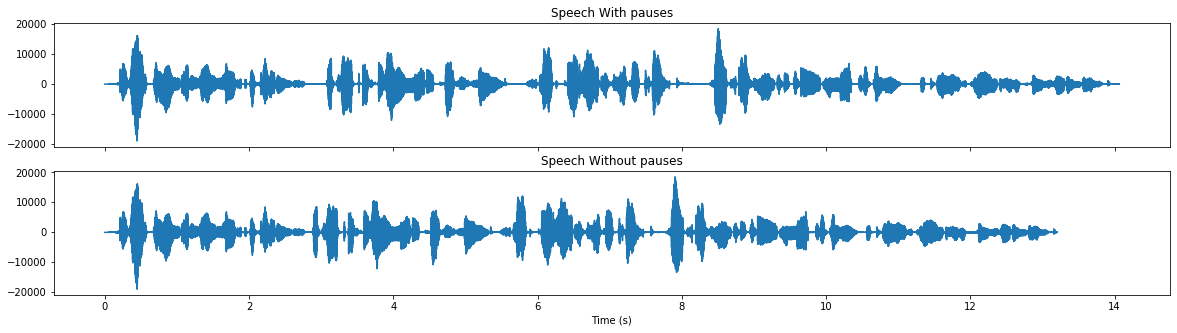

In [221]:

data_nonsilent = data
print(inds)

print(inds)
l = []
for i in range(0, len(inds)-1, 2):
    l.append( data_nonsilent[inds[i]:inds[i+1]])
short = np.concatenate(l,axis=None)

new_time = np.arange(len(short))/rate

fig, ax = plt.subplots(2, 1, sharex=True, figsize=[20, 5])
ax[0].plot(time, data)
ax[1].plot(new_time, short)
ax[0].set_title('Speech With pauses')
ax[1].set_title('Speech Without pauses')
ax[1].set_xlabel('Time (s)')

In [222]:
Audio(data=short, rate=rate )

In [223]:
Audio(data=data, rate=rate )

# Viola!!!

In [628]:
f, t, signal_stft = signal.stft(data, rate, nperseg=882, noverlap=441) # data, nperseg, noverlap (50%)
Zsignal = librosa.power_to_db(np.abs(signal_stft**2), ref=np.max) # returns S_db ~= 10 * log10(S) - 10 * log10(ref)
print(Zsignal.shape)

(442, 512)


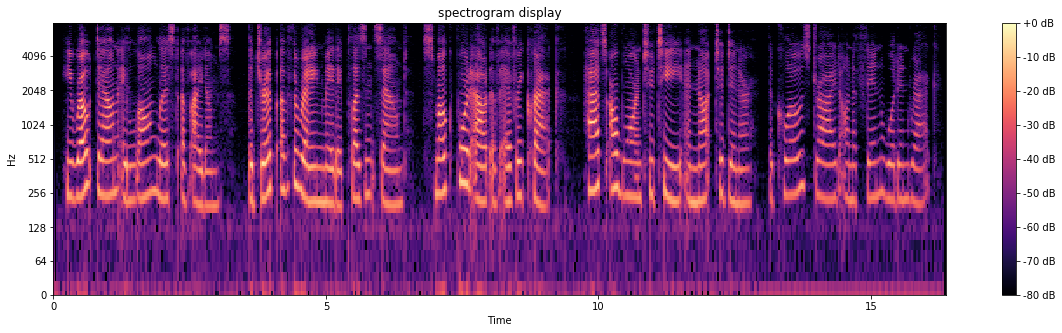

In [18]:
fig, ax= plt.subplots(figsize=[20, 5])
img = librosa.display.specshow(Zsignal,
                          sr=rate, y_axis='log', x_axis='time')
ax.set(title='spectrogram display')
fig.colorbar(img, ax=ax, format="%+2.f dB")